# Video Object Detection using YOLOv3
src : https://towardsdatascience.com/yolo-v3-object-detection-53fb7d3bfe6b

In [6]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

### Standard Library
import cv2
from IPython.display import clear_output
import time
import PIL.Image
from io import BytesIO
import IPython.display
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

### Yolov3 Library
from utils.utils import get_yolo_boxes, makedirs
from utils.utils import preprocess_input,decode_netout,correct_yolo_boxes,do_nms
from utils.bbox import draw_boxes

### Keras Library
import keras
from keras.models import load_model
import keras.backend as K

### TensorRT and Tensorflow Library
from tensorflow.python.platform import gfile
from tensorflow.core.protobuf import config_pb2 as cpb2
from tensorflow.python.framework import ops as ops
from tensorflow.python.ops import array_ops as aops
from tensorflow.python.framework import importer as importer
from tensorflow.python.client import session as csess

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

# Set number of GPUs
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [7]:
###############################
#   Set some parameter
###############################       
net_h, net_w = 416, 416 # a multiple of 32, the smaller the faster

obj_thresh, nms_thresh = 0.5, 0.45

anchor = [10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326]

labels = ["person","bicycle","car","motorbike","aeroplane","bus","train","truck","boat","traffic light","fire hydrant","stop sign","parking meter",
          "bench","bird","cat","dog","horse","sheep","cow","elephant","bear","zebra","giraffe","backpack","umbrella","handbag","tie","suitcase","frisbee",
          "skis","snowboard","sports ball","kite","baseball bat","baseball glove","skateboard","surfboard","tennis racket","bottle","wine glass","cup","fork",
          "knife","spoon","bowl","banana","apple","sandwich","orange","broccoli","carrot","hot dog","pizza","donut","cake","chair","sofa","pottedplant","bed",
          "diningtable","toilet","tvmonitor","laptop","mouse","remote","keyboard","cell phone","microwave","oven","toaster","sink","refrigerator","book","clock",
          "vase","scissors","teddy bear","hair drier","toothbrush"]

# Load model
infer2_model = load_model("yolov3.h5")

##create output folder
output_path  = 'output/'
makedirs(output_path)

In [8]:
#Use 'jpeg' instead of 'png' (~5 times faster)

def showarray(a, fmt='jpeg'):
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    
def get_frame(cam):
    # Capture frame-by-frame
    ret, frame = cam.read()
    #flip image for natural viewing
    frame = cv2.flip(frame, 1)
    return frame

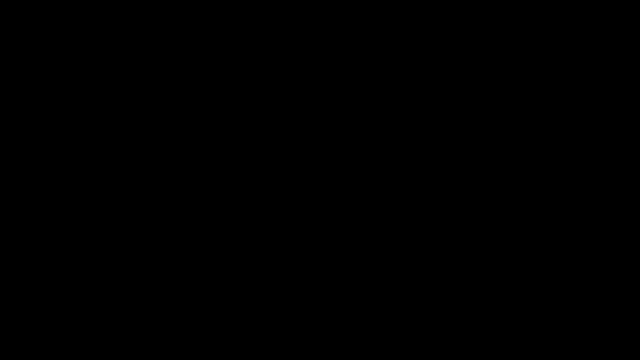

100%|██████████| 902/902 [1:09:20<00:00,  4.61s/it]

predict time = 4124.852440 sec
Finish render video with prediction


In [9]:
# run yolov3 on the video 

input_path = 'video/HitachiDemo.mp4'
 
video_out = output_path + input_path.split('/')[-1]
video_reader = cv2.VideoCapture(input_path)

nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

video_writer = cv2.VideoWriter(video_out,cv2.VideoWriter_fourcc(*'MP4V'), 25.0,(frame_w, frame_h))

# set batch size 2^n
batch_size  = 1
images      = []
start_point = 0 
show_window = True
keras_time_count = 0

for i in tqdm(range(nb_frames)):
    _, image = video_reader.read()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if (float(i+1)/nb_frames) > start_point/100.:
        images += [image]
        
        if (i%batch_size == 0) or (i == (nb_frames-1) and len(images) > 0):
            # predict the bounding boxes
            t1 = time.time()
            batch_boxes = get_yolo_boxes(infer2_model, images, net_h, net_w, anchor, obj_thresh, nms_thresh)
            t2 = time.time()
            keras_time_count += (t2-t1)
            
            for p in range(len(images)):
                # draw bounding boxes on the image using labels
                draw_boxes(images[p], batch_boxes[p], labels , obj_thresh)   
                
                clear_output(wait=True)
                # show the video with detection bounding boxes   
                if show_window: 
                    frame = cv2.resize(images[p],(640,360))
                    showarray(frame)
                    
                # write result to the output video
                images[p] = cv2.cvtColor(images[p], cv2.COLOR_RGB2BGR) # Convert color back
                video_writer.write(images[p]) 
            images = []
        
video_reader.release()
video_writer.release()   
print("predict time = %f sec" % (keras_time_count))
print("Finish render video with prediction")